# ARSET OCO-2 Test Notebook using 'earthaccess' library with Integrated Data Download, Monthly Averaging, Monthly Average Difference Comparison, Plotting, and Exported Image Files

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/moronidav/binders/6e8eda4c0d7dac6c3d06e57b55a13b2170f96d71?urlpath=lab%2Ftree%2Farset-oco-earthaccess-download-analysis-2024-test-query-download-monthly-ave-compare-visualize-export-4binder.ipynb)

**Summary:**

For demonstration and test purposes only. 

The target dataset in this notebook is the **OCO-2 Level 2 bias-corrected XCO2 and other select fields from the full-physics retrieval aggregated as daily files, Retrospective processing V11.1r (OCO2_L2_Lite_FP; DOI: 10.5067/8E4VLCK16O6Q)** from the NASA GES DISC; ([click here for details](https://daac.gsfc.nasa.gov/datasets/OCO2_L2_Lite_FP_11.1r/summary)).

Before proceeding, an **Earthdata Login Account** ([click here to verify existing or create a new account](https://urs.earthdata.nasa.gov/users/new)) is required to execute this notebook. 

Once your **Earthdata Login Account** is verified, you will need to approve access to the **NASA GES DISC Archive** in your **Earthdata Login Profile** ([click here for instructions](https://disc.gsfc.nasa.gov/earthdata-login)).

**Optional:** A .netrc file containing individual **NASA Earthdata Login** credentials (not supplied with this notebook) may be provided by each user intending to operate this notebook locally or from within their preferred Jupyter environment. To create/modify a **.netrc** file, go to your home directory, create a new .netrc file (if not already present), and enter your **Earthdata Login** credentials on a new, empty line as shown below:
     <br>`machine urs.earthdata.nasa.gov login <your username> password <your password>`

**Other important notes:**

  1. If operating this notebook locally or in another managed environment, please "trust" this notebook before executing; this will prevent errors when writing output to your local directory.
  2. This notebook is only meant for initial training and demonstration of the utility of these datasets in support of the OCO-2/OCO-3 Applied Remote Sensing Training (ARSET); for full details, please refer to: [https://appliedsciences.nasa.gov/get-involved/training/english/arset-applications-carbon-dioxide-measurements-climate-related](https://appliedsciences.nasa.gov/get-involved/training/english/arset-applications-carbon-dioxide-measurements-climate-related).
  3. This notebook is designed to function "as-is" for the scope of the training exercise; as code dependencies and data sources periodically become deprecated or updated, the users of these notebooks bear the responsibility to maintain and/or repurpose these notebooks and associated dependencies in a workable state beyond scope of initial training. 

## Notebook Author / Affiliation

David F. Moroni (david.f.moroni@jpl.nasa.gov) / Jet Propulsion Laboratory, Californa Institute of Technology

### Date Authored

12 June 2024

### Date Last Modified

9 June 2025 - Refactored by David F. Moroni for Binder.

### Collaborators
  1. Karen Yuen (karen.yuen@jpl.nasa.gov) / Jet Propulsion Laboratory, Californa Institute of Technology

  2. Junjie Liu (junjie.liu@jpl.nasa.gov) / Jet Propulsion Laboratory, Californa Institute of Technology

### Acknowledgements

This notebook was produced to support the OCO-2/OCO-3 Applied Remote Sensing Training (ARSET) training session. For full details, please refer to [https://appliedsciences.nasa.gov/get-involved/training/english/arset-applications-carbon-dioxide-measurements-climate-related](https://appliedsciences.nasa.gov/get-involved/training/english/arset-applications-carbon-dioxide-measurements-climate-related).

Passive contriutions were also incorporated via open-source Python code made available through the NASA/JPL TRopospheric Ozone and its Precursors from Earth System Sounding (TROPESS) Project, NASA Openscapes, the National Snow and Ice Data Center (NSIDC), and NASA's Goddard Earth Sciences Data and Information Services Center (GES DISC). 

The research was carried out at the Jet Propulsion Laboratory, California Institute of Technology, under a contract with the National Aeronautics and Space Administration (80NM0018D0004). Government sponsorship acknowledged.

In [1]:
import os
import requests
import earthaccess
from earthaccess import Auth, Store, DataCollections, DataGranules
auth = Auth()

import datetime
import contextlib

from pathlib import Path

import pandas as pd
import glob

import numpy as np
import netCDF4
from netCDF4 import Dataset

import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap

from scipy.interpolate import griddata

## Verify Successful Authentication to NASA Earthdata.
### Prompt for NASA Earthdata Login Credentials (i.e., assumes a .netrc file doesn't already exist).
### For the purposes of usage as a Binder, user authentication will be interactive and ephemeral (i.e., credentials are only passed through via a secure API for validation and not stored on the server). 

In [2]:
%%time
auth = earthaccess.login(strategy="interactive", persist=False)

# Optional: For users intending to download and run this notebook locally via static authentication using .netrc file (see comments in the 
# top Summary section), users may invoke the commented line below, and change the "persist" argument in the above line to "persist=True".
# auth.login(strategy="netrc")

authvalid = auth.authenticated
print('Authenication Valid =',authvalid)

# The Store() class enables download or access to data and is instantiated with the user's auth instance.
store = Store(auth)

Authenication Valid = True
CPU times: user 45.5 ms, sys: 18.3 ms, total: 63.8 ms
Wall time: 4.29 s


## Now we will create the local output directory paths if they do not already exist.

In [3]:
%%time
data_dir_check = os.path.isdir('data')
print("Data directory exists: ",data_dir_check)

if data_dir_check != True: 
    os.makedirs('data')
    print("Created local data directory")

Data directory exists:  True
CPU times: user 254 μs, sys: 109 μs, total: 363 μs
Wall time: 328 μs


# Create a Function for CMR Catalog Requests

In [4]:
def cmr_request(params):
    response = requests.get(url,
                        params=params,
                        headers={
                            'Accept': 'application/json',
                        }
                       )
    return response

## Check that the CMR catalog can be accessed

If "200, CMR is accessible" is returned, the catalog can be accessed!

In [5]:
%%time
url = 'https://cmr.earthdata.nasa.gov/search/collections'

# Create our request to check that we can access CMR
response = cmr_request(url)

if response.status_code == 200:
    print(str(response.status_code) + ", CMR is accessible")
else:
    print(str(response.status_code) + ", CMR is not accessible, check for outages")

200, CMR is accessible
CPU times: user 9.54 ms, sys: 5.95 ms, total: 15.5 ms
Wall time: 723 ms


## Query CMR for the dataset shortname using the DOI (digital object identifier)

In [6]:
%%time
# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' # define the base url of NASA's CMR API as the variable `cmrurl`
doi = '10.5067/8E4VLCK16O6Q'                   # OCO-2 dataset DOI

doisearch = cmrurl + 'collections.json?doi=' + doi
print(doisearch)

shortname = requests.get(doisearch).json()['feed']['entry'][0]['short_name']
longname = requests.get(doisearch).json()['feed']['entry'][0]['dataset_id']
version_id = requests.get(doisearch).json()['feed']['entry'][0]['version_id']
print('Short Name = '+shortname)
print('Long Name = '+longname)
print('Version Identifier = '+version_id)

https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.5067/8E4VLCK16O6Q
Short Name = OCO2_L2_Lite_FP
Long Name = OCO-2 Level 2 bias-corrected XCO2 and other select fields from the full-physics retrieval aggregated as daily files, Retrospective processing V11.1r (OCO2_L2_Lite_FP) at GES DISC
Version Identifier = 11.1r
CPU times: user 24.9 ms, sys: 10.7 ms, total: 35.6 ms
Wall time: 434 ms


## Specify netCDF Variable input parameters

In [7]:
# Define the quality flag variabe to utilize; in this case, we select 'xco2_quality_flag'.
qfvar = 'xco2_quality_flag'

# Define Measurement Variable Type; in this test case, we select 'xco2'.
measurement = 'xco2'

## Specify March 2016 input parameters and execute the CMR query for matching granules

In [8]:
%%time
# Define the start and end date/time (YYYY-MM-DD).
start_time = '2016-03-01'
end_time = '2016-03-31'

# CMR Query for Data Granules
query = DataGranules().short_name(shortname).version(version_id).temporal(start_time, end_time)

# How many granules are located in the query?
print(f"Granule hits: {query.hits()}")

# Extract all available granule metadata from the query; invoking "-1" for all avaialble granules.
granules = query.get()

# Print sample list of granule metadata
granules[0:1]

Granule hits: 29
CPU times: user 13.6 ms, sys: 5.23 ms, total: 18.8 ms
Wall time: 336 ms


[Collection: {'ShortName': 'OCO2_L2_Lite_FP', 'Version': '11.1r'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 90.0, 'SouthBoundingCoordinate': -90.0}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2016-02-29T00:00:00.000Z', 'EndingDateTime': '2016-03-01T00:00:00.000Z'}}
 Size(MB): 50.449527740478516
 Data: ['https://data.gesdisc.earthdata.nasa.gov/data/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2016/oco2_LtCO2_160229_B11100Ar_230531231704s.nc4']]

## If previous cell produced nonzero Granule hits, execute next cell to download the data files

In [9]:
%%time
try:
    files = store.get(granules[:], local_path="./data")
except Exception as e:
    print(f"Error: {e}, we are probably not using this code in the Amazon cloud. Trying external links...")
    # There is hope, even if we are not in the Amazon cloud we can still get the data
    files = store.get(granules[:], access="external", local_path="./data")

QUEUEING TASKS | :   0%|          | 0/29 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/29 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/29 [00:00<?, ?it/s]

CPU times: user 781 ms, sys: 1.58 s, total: 2.36 s
Wall time: 19 s


## Let's read the first month of daily data files, make a time series, and then make a monthly average of Total Column CO2. 

In [10]:
%%time
time_series_a = []
version_str = 'B11100Ar'
file = ''

# Loop through the date range and plot Carbon Dioxide for each day
for current_date in pd.date_range(start_time, end_time):
    # Open the netCDF file
    file_date = current_date.strftime("%y%m%d")
    file_path_prefix = './data/oco2_LtCO2_'+file_date+'_'+version_str+'_'
    file_path = glob.glob(file_path_prefix+'*.nc4')

    if file_path != []:
        print('File date = ',file_date)
        #print('File path prefix = ',file_path_prefix)
        print('File path = ',file_path)

        file = file.join(file_path)
         
        # Open the netCDF file
        dataset = Dataset(f'{file}', 'r')
        print("reading data from =", file_date)
        
        # Read the data from your variables
        latitude = dataset.variables['latitude'][:]
        longitude = dataset.variables['longitude'][:]
        x_meas = dataset.variables[measurement][:]
        qf = dataset.variables[qfvar][:]
        
        dataset.close()
    
        # Filter the data for latitude and longitude
        latitude_max = 30.0
        latitude_min = -30.0
        longitude_max = 180.0
        longitude_min = -180.0

        # Determine the subset selection by latitude and longitude bounding box and quality flag (0 = good)
        selection_only = np.where(
            (latitude > latitude_min) & (latitude < latitude_max) & 
            (longitude > longitude_min) &(longitude < longitude_max) & (qf == 0)
        )[0]

        # Apply the subset selection to data variables
        latitude = latitude[selection_only]
        longitude = longitude[selection_only]
        x_meas = x_meas[selection_only]
        
        pixel_size_deg = 5.0 # 5x5 degree grid resolution
    
        # Get the grid for the interpolated values
        grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
    
        # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
        grid_x = griddata((latitude, longitude), x_meas, (grid_lat, grid_lon), method='nearest', rescale=True)
    
        time_series_a.append(grid_x)

time_series_a = np.array(time_series_a)    
print(time_series_a.shape)
x_meas_month_mean_a = np.mean(time_series_a, axis=0)

File date =  160301
File path =  ['./data/oco2_LtCO2_160301_B11100Ar_230531213947s.nc4']
reading data from = 160301
File date =  160302
File path =  ['./data/oco2_LtCO2_160302_B11100Ar_230531232204s.nc4']
reading data from = 160302
File date =  160303
File path =  ['./data/oco2_LtCO2_160303_B11100Ar_230531232358s.nc4']
reading data from = 160303
File date =  160304
File path =  ['./data/oco2_LtCO2_160304_B11100Ar_230531232521s.nc4']
reading data from = 160304
File date =  160305
File path =  ['./data/oco2_LtCO2_160305_B11100Ar_230531232556s.nc4']
reading data from = 160305
File date =  160306
File path =  ['./data/oco2_LtCO2_160306_B11100Ar_230531232620s.nc4']
reading data from = 160306
File date =  160307
File path =  ['./data/oco2_LtCO2_160307_B11100Ar_230531232653s.nc4']
reading data from = 160307
File date =  160308
File path =  ['./data/oco2_LtCO2_160308_B11100Ar_230531232905s.nc4']
reading data from = 160308
File date =  160309
File path =  ['./data/oco2_LtCO2_160309_B11100Ar_230

## Generate Lat/Lon Map Plot

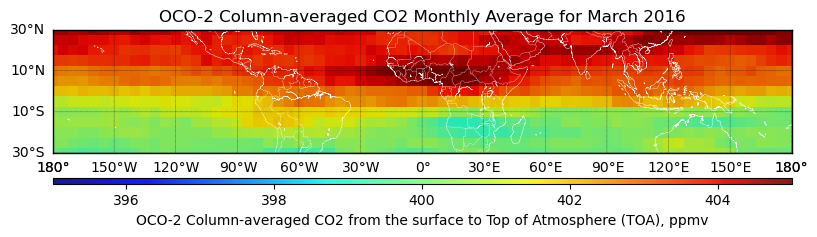

In [11]:
    # Calculate width and height
    aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
    w = 3600; h = w / aspect_ratio

    # Specify figure size (in inches)
    dpi = 300; 
    plt.figure(figsize=(w / dpi, h / dpi))  

    # Create a basemap instance
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
                llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')

    # Draw parallels (latitude lines) and meridians (longitude lines)
    parallels = np.arange(latitude_min, latitude_max+1, 20.)
    m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

    meridians = np.arange(longitude_min, longitude_max+1, 30.)
    m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)
    
    pixel_size_deg = 5.0 # 5 degree resolution

    # Get the grid for the interpolated values
    grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
    
    # Plot the interpolated data using pcolormesh instead of scatter
    sc = m.pcolormesh(grid_lon, grid_lat, x_meas_month_mean_a, latlon=True, cmap='jet', alpha=0.9, vmin=395.0, vmax=405.0, shading='auto')
    
    # Add a colorbar
    cbar = m.colorbar(sc, location='bottom', pad="20%")
    cbar.set_label('OCO-2 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppmv')

    # set plot title
    title_date = current_date.strftime("%b-%Y")
    plt.title(f'OCO-2 Column-averaged CO2 Monthly Average for March 2016')
    #\nMin: {title_min:.01f}, Max: {title_max:.01f} ppmv')

    # Save figure to PNG file
    plt.savefig(f'./data/oco2_co2_month_average_march_2016_qf.png', dpi=dpi, bbox_inches='tight')

    plt.show()
    plt.close()


## Specify March 2015 input parameters and execute the CMR query for matching granules

In [12]:
%%time
# Define the start and end date/time (YYYY-MM-DD).
start_time = '2015-03-01'
end_time = '2015-03-31'

print('Version = ', version_id)

# CMR Query for Data Granules
query = DataGranules().short_name(shortname).version(version_id).temporal(start_time, end_time)

# How many granules are located in the query?
print(f"Granule hits: {query.hits()}")

# Extract all available granule metadata from the query; invoking "-1" for all avaialble granules.
granules = query.get()

# Print sample list of granule metadata
granules[0:1]

Version =  11.1r
Granule hits: 32
CPU times: user 17.7 ms, sys: 7.05 ms, total: 24.7 ms
Wall time: 803 ms


[Collection: {'ShortName': 'OCO2_L2_Lite_FP', 'Version': '11.1r'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 90.0, 'SouthBoundingCoordinate': -90.0}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2015-02-28T00:00:00.000Z', 'EndingDateTime': '2015-03-01T00:00:00.000Z'}}
 Size(MB): 25.546317100524902
 Data: ['https://data.gesdisc.earthdata.nasa.gov/data/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2015/oco2_LtCO2_150228_B11100Ar_230524230444s.nc4']]

## If previous cell produced nonzero Granule hits, execute next cell to download the data files

In [13]:
%%time
try:
    files = store.get(granules[:], local_path="./data")
except Exception as e:
    print(f"Error: {e}, we are probably not using this code in the Amazon cloud. Trying external links...")
    # There is hope, even if we are not in the Amazon cloud we can still get the data
    files = store.get(granules[:], access="external", local_path="./data")

QUEUEING TASKS | :   0%|          | 0/32 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/32 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/32 [00:00<?, ?it/s]

CPU times: user 734 ms, sys: 1.44 s, total: 2.17 s
Wall time: 18 s


## Let's read the first month of daily data files, make a time series, and then make a monthly average of Total Column CO2. 

In [14]:
%%time
time_series_b = []
version_str = 'B11100Ar'
file = ''

# Loop through the date range and plot Carbon Dioxide for each day
for current_date in pd.date_range(start_time, end_time):
    # Open the netCDF file
    file_date = current_date.strftime("%y%m%d")
    file_path_prefix = './data/oco2_LtCO2_'+file_date+'_'+version_str+'_'
    file_path = glob.glob(file_path_prefix+'*.nc4')

    if file_path != []:
        print('File date = ',file_date)
        #print('File path prefix = ',file_path_prefix)
        print('File path = ',file_path)

        file = file.join(file_path)
         
        # Open the netCDF file
        dataset = Dataset(f'{file}', 'r')
        print("reading data from =", file_date)
        
        # Read the data from your variables
        latitude = dataset.variables['latitude'][:]
        longitude = dataset.variables['longitude'][:]
        x_meas = dataset.variables[measurement][:]
        qf = dataset.variables[qfvar][:]
        
        dataset.close()
    
        # Filter the data for latitude and longitude
        latitude_max = 30.0
        latitude_min = -30.0
        longitude_max = 180.0
        longitude_min = -180.0

        # Determine the subset selection by latitude and longitude bounding box and quality flag (0 = good)
        selection_only = np.where(
            (latitude > latitude_min) & (latitude < latitude_max) & 
            (longitude > longitude_min) &(longitude < longitude_max) & (qf == 0)
        )[0]

        # Apply the subset selection to data variables
        latitude = latitude[selection_only]
        longitude = longitude[selection_only]
        x_meas = x_meas[selection_only]
        
        pixel_size_deg = 5.0 # 5x5 degree grid resolution
    
        # Get the grid for the interpolated values
        grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
    
        # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
        grid_x = griddata((latitude, longitude), x_meas, (grid_lat, grid_lon), method='nearest', rescale=True)
           
        # Make the time series of daily x_col for one month by appending each day's dataset. 
        time_series_b.append(grid_x)

time_series_b = np.array(time_series_b)    
print(time_series_b.shape)
x_meas_month_mean_b = np.mean(time_series_b, axis=0)

File date =  150301
File path =  ['./data/oco2_LtCO2_150301_B11100Ar_230524222700s.nc4']
reading data from = 150301
File date =  150302
File path =  ['./data/oco2_LtCO2_150302_B11100Ar_230524230459s.nc4']
reading data from = 150302
File date =  150303
File path =  ['./data/oco2_LtCO2_150303_B11100Ar_230524230509s.nc4']
reading data from = 150303
File date =  150304
File path =  ['./data/oco2_LtCO2_150304_B11100Ar_230524230659s.nc4']
reading data from = 150304
File date =  150305
File path =  ['./data/oco2_LtCO2_150305_B11100Ar_230524230809s.nc4']
reading data from = 150305
File date =  150306
File path =  ['./data/oco2_LtCO2_150306_B11100Ar_230524230822s.nc4']
reading data from = 150306
File date =  150307
File path =  ['./data/oco2_LtCO2_150307_B11100Ar_230524230824s.nc4']
reading data from = 150307
File date =  150308
File path =  ['./data/oco2_LtCO2_150308_B11100Ar_230524231021s.nc4']
reading data from = 150308
File date =  150309
File path =  ['./data/oco2_LtCO2_150309_B11100Ar_230

## Generate Lat/Lon Map Plot

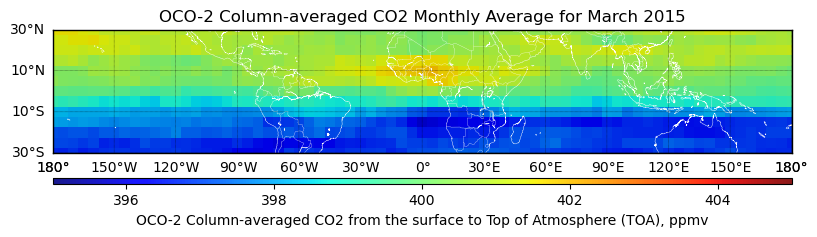

In [15]:
    # Calculate width and height
    aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
    w = 3600; h = w / aspect_ratio

    # Specify figure size (in inches)
    dpi = 300; 
    plt.figure(figsize=(w / dpi, h / dpi))  

    # Create a basemap instance
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
                llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')
    #m.drawstates(linewidth=0.2, color='white')


    # Draw parallels (latitude lines) and meridians (longitude lines)
    parallels = np.arange(latitude_min, latitude_max+1, 20.)
    m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

    meridians = np.arange(longitude_min, longitude_max+1, 30.)
    m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)
    
    pixel_size_deg = 5.0 # 5 degree resolution

    # Get the grid for the interpolated values
    grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
    
    # Plot the interpolated data using pcolormesh instead of scatter
    sc = m.pcolormesh(grid_lon, grid_lat, x_meas_month_mean_b, latlon=True, cmap='jet', alpha=0.9, vmin=395.0, vmax=405.0, shading='auto')
    
    # Add a colorbar
    cbar = m.colorbar(sc, location='bottom', pad="20%")
    cbar.set_label('OCO-2 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppmv')

    # set plot title
    title_date = current_date.strftime("%b-%Y")
    plt.title(f'OCO-2 Column-averaged CO2 Monthly Average for March 2015')
    #\nMin: {title_min:.01f}, Max: {title_max:.01f} ppbm')

    # Save figure to PNG file
    plt.savefig(f'./data/oco2_co2_month_average_march_2015_qf.png', dpi=dpi, bbox_inches='tight')

    plt.show()
    plt.close()

## Let's compute the difference between the monthly averaged XCO2 and plot the difference in a global map. 

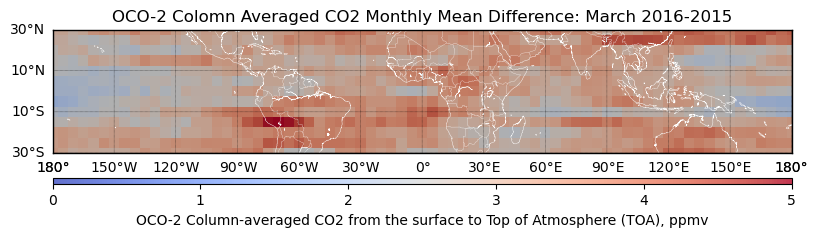

In [16]:
    x_meas_diff_month_mean = x_meas_month_mean_a - x_meas_month_mean_b
 
    # Calculate width and height
    aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
    w = 3600; h = w / aspect_ratio

    # Specify figure size (in inches)
    dpi = 300; 
    plt.figure(figsize=(w / dpi, h / dpi))  

    # Create a basemap instance
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
                llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')

    # Draw parallels (latitude lines) and meridians (longitude lines)
    parallels = np.arange(latitude_min, latitude_max+1, 20.)
    m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

    meridians = np.arange(longitude_min, longitude_max+1, 30.)
    m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)
    
    pixel_size_deg = 5.0 # 5 degree resolution

    # Get the grid for the interpolated values
    grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
    
    # Plot the difference data using pcolormesh instead of scatter
    sc = m.pcolormesh(grid_lon, grid_lat, x_meas_diff_month_mean, latlon=True, cmap='coolwarm', alpha=0.8, vmin=0.0, vmax=5.0, shading='auto')

    # Add a colorbar
    cbar = m.colorbar(sc, location='bottom', pad="20%")
    cbar.set_label('OCO-2 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppmv')

    # set plot title
    title_date = current_date.strftime("%b-%Y")
    plt.title(f'OCO-2 Colomn Averaged CO2 Monthly Mean Difference: March 2016-2015')
    #' \nMin: {title_min:.01f}, Max: {title_max:.01f} ppmv')

    # Save figure to PNG file
    plt.savefig(f'./data/oco2_co2_2016_2015_March_month_diff_qf.png', dpi=dpi, bbox_inches='tight')

    plt.show()
    plt.close()

## Specify March 2017 input parameters and execute the CMR query for matching granules

In [17]:
%%time
# Define the start and end date/time (YYYY-MM-DD).
start_time = '2017-03-01'
end_time = '2017-03-31'

# CMR Query for Data Granules
query = DataGranules().short_name(shortname).version(version_id).temporal(start_time, end_time)

# How many granules are located in the query?
print(f"Granule hits: {query.hits()}")

# Extract all available granule metadata from the query; invoking "-1" for all avaialble granules.
granules = query.get()

# Print sample list of granule metadata
granules[0:1]

Granule hits: 32
CPU times: user 17.3 ms, sys: 7.27 ms, total: 24.6 ms
Wall time: 1.01 s


[Collection: {'ShortName': 'OCO2_L2_Lite_FP', 'Version': '11.1r'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 90.0, 'SouthBoundingCoordinate': -90.0}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2017-02-28T00:00:00.000Z', 'EndingDateTime': '2017-03-01T00:00:00.000Z'}}
 Size(MB): 51.03492069244385
 Data: ['https://data.gesdisc.earthdata.nasa.gov/data/OCO2_DATA/OCO2_L2_Lite_FP.11.1r/2017/oco2_LtCO2_170228_B11100Ar_230601171308s.nc4']]

## If previous cell produced nonzero Granule hits, execute next cell to download the data files

In [18]:
%%time
try:
    files = store.get(granules[:], local_path="./data")
except Exception as e:
    print(f"Error: {e}, we are probably not using this code in the Amazon cloud. Trying external links...")
    # There is hope, even if we are not in the Amazon cloud we can still get the data
    files = store.get(granules[:], access="external", local_path="./data")

QUEUEING TASKS | :   0%|          | 0/32 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/32 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/32 [00:00<?, ?it/s]

CPU times: user 876 ms, sys: 1.82 s, total: 2.7 s
Wall time: 20.9 s


## Let's read the first month of daily data files, make a time series, and then make a monthly average of Total Column CO2. 

In [19]:
%%time
time_series_c = []
version_str = 'B11100Ar'
file = ''

# Loop through the date range and plot Carbon Dioxide for each day
for current_date in pd.date_range(start_time, end_time):
    # Open the netCDF file
    file_date = current_date.strftime("%y%m%d")
    file_path_prefix = './data/oco2_LtCO2_'+file_date+'_'+version_str+'_'
    file_path = glob.glob(file_path_prefix+'*.nc4')

    if file_path != []:
        print('File date = ',file_date)
        #print('File path prefix = ',file_path_prefix)
        print('File path = ',file_path)

        file = file.join(file_path)
         
        # Open the netCDF file
        dataset = Dataset(f'{file}', 'r')
        print("reading data from =", file_date)
        
        # Read the data from your variables
        latitude = dataset.variables['latitude'][:]
        longitude = dataset.variables['longitude'][:]
        x_meas = dataset.variables[measurement][:]
        qf = dataset.variables[qfvar][:]
        
        dataset.close()
    
        # Filter the data for latitude and longitude
        latitude_max = 30.0
        latitude_min = -30.0
        longitude_max = 180.0
        longitude_min = -180.0

        # Determine the subset selection by latitude and longitude bounding box and quality flag (0 = good)
        selection_only = np.where(
            (latitude > latitude_min) & (latitude < latitude_max) & 
            (longitude > longitude_min) &(longitude < longitude_max) & (qf == 0)
        )[0]

        # Apply the subset selection to data variables
        latitude = latitude[selection_only]
        longitude = longitude[selection_only]
        x_meas = x_meas[selection_only]
        
        pixel_size_deg = 5.0 # 5x5 degree grid resolution
    
        # Get the grid for the interpolated values
        grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
    
        # Bin the data on a consistent lat/lon grid using griddata using nearest neighbor binning; for bi-linear, use method='linear'
        grid_x = griddata((latitude, longitude), x_meas, (grid_lat, grid_lon), method='nearest', rescale=True)
      
        # Make the time series of daily x_col for one month by appending each day's dataset. 
        time_series_c.append(grid_x)

time_series_c = np.array(time_series_c)    
print(time_series_c.shape)
x_meas_month_mean_c = np.mean(time_series_c, axis=0)

File date =  170301
File path =  ['./data/oco2_LtCO2_170301_B11100Ar_230601171436s.nc4']
reading data from = 170301
File date =  170302
File path =  ['./data/oco2_LtCO2_170302_B11100Ar_230601171439s.nc4']
reading data from = 170302
File date =  170303
File path =  ['./data/oco2_LtCO2_170303_B11100Ar_230601171512s.nc4']
reading data from = 170303
File date =  170304
File path =  ['./data/oco2_LtCO2_170304_B11100Ar_230601171649s.nc4']
reading data from = 170304
File date =  170305
File path =  ['./data/oco2_LtCO2_170305_B11100Ar_230601171702s.nc4']
reading data from = 170305
File date =  170306
File path =  ['./data/oco2_LtCO2_170306_B11100Ar_230601171931s.nc4']
reading data from = 170306
File date =  170307
File path =  ['./data/oco2_LtCO2_170307_B11100Ar_230601171932s.nc4']
reading data from = 170307
File date =  170308
File path =  ['./data/oco2_LtCO2_170308_B11100Ar_230601171949s.nc4']
reading data from = 170308
File date =  170309
File path =  ['./data/oco2_LtCO2_170309_B11100Ar_230

## Generate Lat/Lon Map Plot

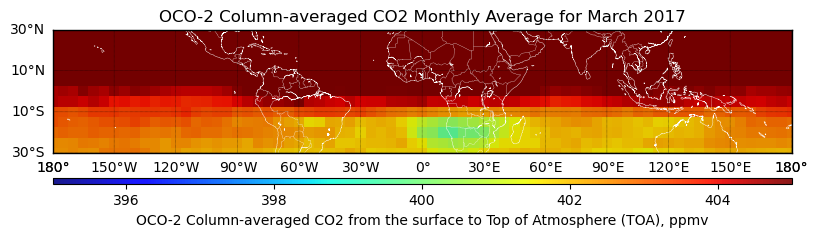

In [20]:
    # Calculate width and height
    aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
    w = 3600; h = w / aspect_ratio

    # Specify figure size (in inches)
    dpi = 300; 
    plt.figure(figsize=(w / dpi, h / dpi))  

    # Create a basemap instance
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
                llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')

    # Draw parallels (latitude lines) and meridians (longitude lines)
    parallels = np.arange(latitude_min, latitude_max+1, 20.)
    m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

    meridians = np.arange(longitude_min, longitude_max+1, 30.)
    m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)
    
    pixel_size_deg = 5.0 # 5 degree resolution

    # Get the grid for the interpolated values
    grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
    
    # Plot the interpolated data using pcolormesh instead of scatter
    sc = m.pcolormesh(grid_lon, grid_lat, x_meas_month_mean_c, latlon=True, cmap='jet', alpha=0.9, vmin=395.0, vmax=405.0, shading='auto') 
    
    # Add a colorbar
    cbar = m.colorbar(sc, location='bottom', pad="20%")
    cbar.set_label('OCO-2 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppmv')

    # set plot title
    title_date = current_date.strftime("%b-%Y")
    plt.title(f'OCO-2 Column-averaged CO2 Monthly Average for March 2017')

    # Save figure to PNG file
    plt.savefig(f'./data/oco2_co2_month_average_march_2017_qf.png', dpi=dpi, bbox_inches='tight')

    plt.show()
    plt.close()

## Let's compute the difference between the monthly averaged XCO2 and plot the difference in a global map. 

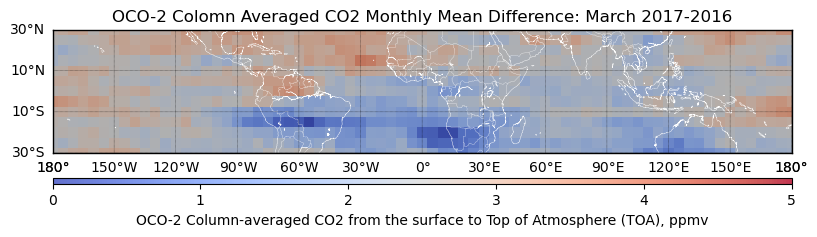

In [21]:
    x_meas_diff_month_mean = x_meas_month_mean_c - x_meas_month_mean_a
 
    # Calculate width and height
    aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
    w = 3600; h = w / aspect_ratio

    # Specify figure size (in inches)
    dpi = 300; 
    plt.figure(figsize=(w / dpi, h / dpi))  

    # Create a basemap instance
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=latitude_min, urcrnrlat=latitude_max,  # set latitude limits as previously defined
                llcrnrlon=longitude_min, urcrnrlon=longitude_max)  # set longitude limits as previously defined

    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')

    # Draw parallels (latitude lines) and meridians (longitude lines)
    parallels = np.arange(latitude_min, latitude_max+1, 20.)
    m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

    meridians = np.arange(longitude_min, longitude_max+1, 30.)
    m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)
    
    pixel_size_deg = 5.0 # 5 degree resolution

    # Get the grid for the interpolated values
    grid_lat, grid_lon = np.mgrid[latitude_min:latitude_max+pixel_size_deg:pixel_size_deg, longitude_min:longitude_max+pixel_size_deg:pixel_size_deg]
    
    # Plot the difference data using pcolormesh instead of scatter
    sc = m.pcolormesh(grid_lon, grid_lat, x_meas_diff_month_mean, latlon=True, cmap='coolwarm', alpha=0.8, vmin=0.0, vmax=5.0, shading='auto')

    # Add a colorbar
    cbar = m.colorbar(sc, location='bottom', pad="20%")
    cbar.set_label('OCO-2 Column-averaged CO2 from the surface to Top of Atmosphere (TOA), ppmv')

    # set plot title
    title_date = current_date.strftime("%b-%Y")
    plt.title(f'OCO-2 Colomn Averaged CO2 Monthly Mean Difference: March 2017-2016')

    # Save figure to PNG file
    plt.savefig(f'./data/oco2_co2_2017_2016_March_month_diff_qf.png', dpi=dpi, bbox_inches='tight')

    plt.show()
    plt.close()